# Notebook for getting S$_{21}$s of resonators vs power

Loading libraries requred below:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time
import pickle
import sys
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
import os

In [3]:
from drivers.Agilent_PNA_L import *
from drivers.znb import *

### Setting the name for the sample

In [4]:
sample_name = "Xmon NbAl 1" #sample name will be used in the filenames
s_param = "S14" # specify where the sample is connected

### Getting the general view S$_{21}$ scan of the sample and detect resonator positions

In [5]:
# vna = Agilent_PNA_L("PNA-L2") # loading the vector network analyser object from the driver
vna = Znb("ZNB")

In [6]:
vna.select_S_param(s_param)

In [7]:
vna.sweep_hold()

In [8]:
vna.set_average_mode("REDUCE")

Setting the parameters of the scan:

In [21]:
vna.set_xlim(7e9, 9e9) # setting the scan area
vna.set_bandwidth(5000)
vna.set_nop(10000)
vna.set_averages(1)
vna.set_power(0)

In [22]:
vna.prepare_for_stb()
vna.sweep_single() # triggering the sweep
vna.wait_for_stb()
vna.autoscale_all()

In [23]:
def guess_scan_areas(area_size, depth):
    '''
    Function to get the approximate positions of the resonator dips and return small areas around them
    Parameters:
    -----------
        area_size : double
        Sets the diams of the returned scan areas (Hz)
        
        depth : double
        Count everything deeper than median transmission depth near a minimum as a resonator dip. 
        Should be chosen manually each time
    Returns:
        scan_areas : list
        A list of tuples each representing an area in frequency presumably around the resonator dips
    '''
    freqs, amps = vna.get_frequencies(), 20*log10(abs(vna.get_sdata()))
    window = 100
    extrema = argrelextrema(amps, np.less, order=window)[0]
    deep_minima = []
    for extremum in extrema:
        mean_transmission = median(amps[extremum-window//2:extremum+window//2])
        if amps[extremum]<mean_transmission-depth:
            deep_minima.append(freqs[extremum])
    return [(m-area_size/2, m+area_size/2) for m in deep_minima]

In [24]:
scan_areas = guess_scan_areas(30e6, 3.5)[:]
scan_areas[:10], len(scan_areas)

([(7653866887.0, 7683866887.0),
  (7737075208.0, 7767075208.0),
  (7821483648.0, 7851483648.0),
  (7910692569.0, 7940692569.0),
  (7991700670.0, 8021700670.0),
  (8078709371.0, 8108709371.0),
  (8626564156.0, 8656564156.0),
  (8823583858.0, 8853583858.0)],
 8)

In [145]:
# scan_areas_prepend = [(5563624000.0, 5564624000.0)]

In [25]:
# manual override for the scan areas, don't use if guessing succeeded
# scan_areas = [(5.6e9, 5.64e9)] 
# scan_areas.append((7.7e9, 7.8e9))
# scan_areas[7] = (7.737e9, 7.741e9)
# scan_areas.insert(-1, (7.48e9, 7.488e9))
# del scan_areas[-2]

In [26]:
# scan_areas = scan_areas+scan_areas_prepend

In [39]:
save_graph = True

plt.plot(vna.get_frequencies(), 20*log10(abs(vna.get_sdata())))

for scan_area in scan_areas:
    plt.plot(scan_area, ones(2)*min(20*log10(abs(vna.get_sdata()))), marker="+")
        
# plt.xlim(scan_areas[7]) # the x-axis limits may are set to a certain scan area to check whether it was guessed correctly
plt.ylim(min(20*log10(abs(vna.get_sdata())))-5,max(20*log10(abs(vna.get_sdata())))+5)
# plt.xlim(6.5e9, 8e9)
plt.minorticks_on()
plt.grid(which="both")
plt.gcf().set_size_inches(15, 3)

# Here the first datafile is created. It is placed in a folder with current date which is also created below.

if save_graph:
    try:
        os.mkdir("./data/"+str(datetime.datetime.now().date()))
    except FileExistsError:
        pass
    with open("./data/"+str(datetime.datetime.now().date())+"/"+sample_name+".pkl", "wb") as f:
        pickle.dump((vna.get_frequencies(), vna.get_sdata()), f)

VisaIOError: VI_ERROR_CONN_LOST (-1073807194): The connection for the given session has been lost.

# Recording a zoomed scan inside each scan area at each power

In [34]:
power_scans = {}
vna.set_nop(1000)
vna.set_bandwidth(5000)
powers = linspace(-50, 10, 61) # the powers we are using to scan through

First we make noise calibration to make sure we will not perform redundant averaging:

In [35]:
def theory_noise_amps_pow(power, exponent, max_noise):
    return max_noise*exp(-power*exponent)
# def theory_noise_amps_avg(average, max_noise):
#     return max_noise/sqrt(average)
def calibrate_noise(scan_area, powers):
    noises = []
    powers = powers[::]
    vna.set_center(mean(scan_area)+10e6)
    vna.set_span(1)
    vna.set_averages(1)
    for power in powers:
        vna.set_power(power)
        vna.prepare_for_stb()
        vna.sweep_single()
        vna.wait_for_stb()
        noises.append(vna.get_sdata())
        print("\rPower:", power, end="")
    noise_amps = [sqrt(mean((abs(noise) - mean(abs(noise)))**2))/mean(abs(noise)) for noise in noises] 
    opt_params = curve_fit(theory_noise_amps_pow, powers, noise_amps, p0=(0.01,0.1))[0]
    return opt_params, noise_amps

In [36]:
opt_params, noise_amps = calibrate_noise(scan_areas[0], powers[::10])

Power: 10.00

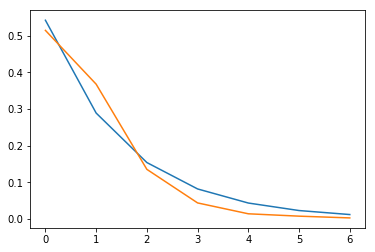

In [37]:
plot(theory_noise_amps_pow(powers[::10], *opt_params))
plot(noise_amps)

In [38]:
time_start = datetime.datetime.now()
print("Started at:", time_start)

print(powers[:5]) # to check the powers are nice whole numbers

# Beginning the scan here             
for scan_area in scan_areas[:-2]:
    S21s = []
    
    opt_params, noise_amps = calibrate_noise(scan_area, powers[::10])
    averages_arr = around(1000*theory_noise_amps_pow(powers, *opt_params)**2)
    averages_arr[averages_arr==0]=1
    vna.set_xlim(*scan_area)
    
    for power, averages in zip(powers, averages_arr):
        vna.set_power(power)
        vna.set_averages(averages)
        print("\r"+str(scan_area), "avg: "+str(averages), "power:"+str(power), end=" ", flush=True)
        
        vna.prepare_for_stb()
        vna.sweep_single()
        vna.wait_for_stb()
        
        vna.autoscale_all()
        S21s.append((vna.get_frequencies(), vna.get_sdata()))
    power_scans[scan_area] = S21s
    print("Done!")
with open("./data/"\
          +str(time_start.date())\
          +"/"+sample_name+"_resonators_on_power.pkl", "wb") as f:
    pickle.dump((scan_areas, powers, power_scans), f)

Started at: 2017-07-27 23:14:44.546988
[-50. -49. -48. -47. -46.]
(7653866887.0, 7683866887.0) avg: 1.0 power:10.0    Done!
(7737075208.0, 7767075208.0) avg: 1.0 power:10.0    Done!
(7821483648.0, 7851483648.0) avg: 1.0 power:10.0    Done!
(7910692569.0, 7940692569.0) avg: 1.0 power:10.0    Done!
(7991700670.0, 8021700670.0) avg: 1.0 power:10.0    Done!
(8078709371.0, 8108709371.0) avg: 1.0 power:10.0    Done!


In [91]:
scan_area = scan_areas[0]
plt.plot(power_scans[scan_area][0][0], 20*log10(abs(power_scans[scan_area][0][1])))
plt.plot(power_scans[scan_area][-1][0], 20*log10(abs(power_scans[scan_area][-1][1])))
plt.gcf().set_size_inches(13,5)

KeyError: (6962016252.0, 6963016252.0)

In [96]:
vna.set_xlim(*scan_areas[1])

##  Noise calibration

In [147]:
peak_vicinity = mean(scan_areas[0])+linspace(-1, 1, 2)

In [178]:
power_scans = {}
vna.set_nop(1000)
vna.set_bandwidth(500)
vna.set_averages(1)

In [179]:
powers = linspace(-60, -30, 31)

In [180]:
noises_pow = []
vna.set_xlim(*peak_vicinity)
    
for power in powers:
    vna.set_power(power)
    vna.prepare_for_stb()
    vna.sweep_single()
    vna.wait_for_stb()
    noises_pow.append(vna.get_sdata())
    print("\rPower:", power, end="")

Power: -30.0

In [199]:
noise_amps = [sqrt(sum(abs(noise - mean(noise))**2)) for noise in noises_pow] 
opt_params = curve_fit(theory_noise_amps_pow, powers, noise_amps, p0=(0.01,0.6))[0]

In [201]:
opt_params

array([ 0.11579542,  0.00053619])

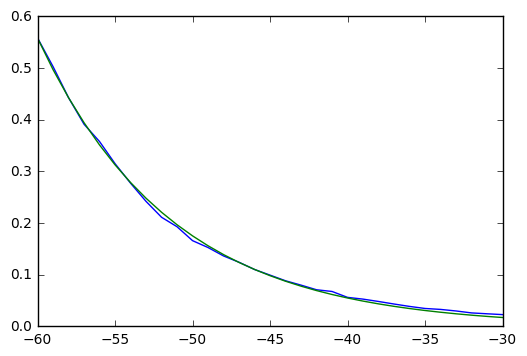

In [200]:
plt.plot(powers, noise_amps)
plt.plot(powers, theory_noise_amps_pow(powers, *opt_params))

In [166]:
averages = linspace(1, 50, 50)

In [168]:
noises = []
vna.set_xlim(*peak_vicinity)
vna.set_power(-60)
for average in averages:
    vna.set_averages(average)
    vna.prepare_for_stb()
    vna.sweep_single()
    vna.wait_for_stb()
    noises.append(vna.get_sdata())
    print("\rAverage:", average, end="")

Average: 25.0

KeyboardInterrupt: 

In [205]:
noise_amps = [sqrt(sum(abs(noise - mean(noise))**2)) for noise in noises] 

In [221]:
opt_params = curve_fit(theory_noise_amps_avg, averages[:25], noise_amps, p0=(1))[0]

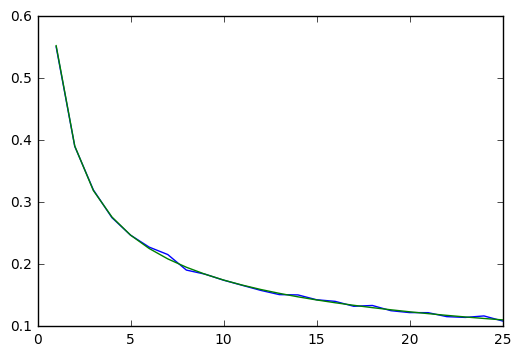

In [223]:
plt.plot(averages[:25], noise_amps)
plt.plot(averages[:25], theory_noise_amps_avg(averages[:25], *opt_params))

In [183]:
X = linspace(1, 25)
Y_pow = exp(-X)
Y_avg = 1/sqrt(X)

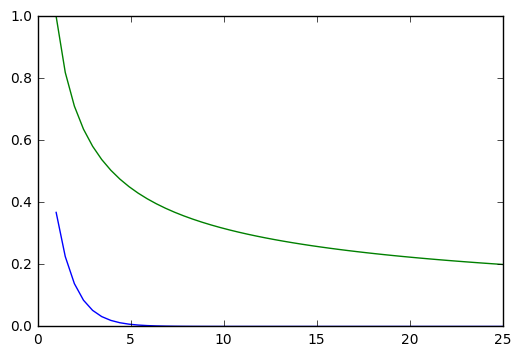

In [184]:
plt.plot(X, Y_pow, X, Y_avg)

In [44]:
mxg

NameError: name 'mxg' is not defined

In [4]:
from importlib import reload

In [8]:
reload(Measurement_AD_1)

<module 'Measurement_AD_1' from 'C:\\Users\\PAINMASTER\\Measurement\\Measurement_AD_1.py'>

In [7]:
import Measurement_AD_1

In [9]:
from Measurement_AD_1 import *


In [10]:
meas = Measurement(['exa'])

exa EXA
The device exa is detected as EXA


In [13]:
meas._exa

In [14]:
meas._exa